In [20]:
import pandas as pd
import gzip
%matplotlib inline

In [21]:
path = "/Users/joshuamalina/Downloads/reviews_Movies_and_TV_5.json.gz"

In [22]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(path)

In [23]:
df.head()

,reviewerName,reviewText,summary,unixReviewTime,reviewerID,reviewTime,overall,asin,helpful
0,"Alice L. Larson ""alice-loves-books""",This is a charming version of the classic Dick...,good version of a classic,1203984000,ADZPIG9QOCDG5,"02 26, 2008",4.0,0005019281,"[0, 0]"
1,Amarah Strack,It was good but not as emotionally moving as t...,Good but not as moving,1388361600,A35947ZP82G7JH,"12 30, 2013",3.0,0005019281,"[0, 0]"
2,Amazon Customer,"Don't get me wrong, Winkler is a wonderful cha...",Winkler's Performance was ok at best!,1388361600,A3UORV8A9D5L2E,"12 30, 2013",3.0,0005019281,"[0, 0]"
3,"Amazon Customer ""Softmill""",Henry Winkler is very good in this twist on th...,It's an enjoyable twist on the classic story,1202860800,A1VKW06X1O2X7V,"02 13, 2008",5.0,0005019281,"[0, 0]"
4,BABE,This is one of the best Scrooge movies out. H...,Best Scrooge yet,1387670400,A3R27T4HADWFFJ,"12 22, 2013",4.0,0005019281,"[0, 0]"


Use a pretrained fast text model plus a discrete classifier (i.e. not regression) to see how well we perform in an 80 / 20 split. 

Should it matter if we do cross validation or just a simple randomized, 80/20 split? What characteristics of the data set would have us favor one form of validation over the other? Perhaps we would do more cross validation if the distribution of our "overall" scores were not represented in each category? And thus our data set would be imbalanced?

Do we need to control for the size of our reviews? Is there a signal in its length? If we compress all the reviews to the same 50 / 100 / 300 dimensional vector size, might we be losing a signal? Should we add in another bit that stands for length of the review?

What about sentiment? Will that be captured by our fast text embedding? We should try on both a pretrained model and one that we train ourselves. Then we should also try to include some sentiment bit (average sentiment vs num pos words vs num negative words) and see if that increases our accuracy.

There are probably a bunch of different ways of calculating sentiment. Maybe we try a few.

Does the method of creating word embeddings / creating sentence embeddings affect classification accuracy? Why would it or wouldn't it? Maybe we can try gensim also.

Are neural nets more or less affected by skewed targets? forest based models are said to be pretty robust to variability. we'll try xgboost to see what our performance is.

In [44]:
# distribution of "overall" scores in the dataset
df['overall'].describe()

count    1.697533e+06
mean     4.110648e+00
std      1.197615e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64

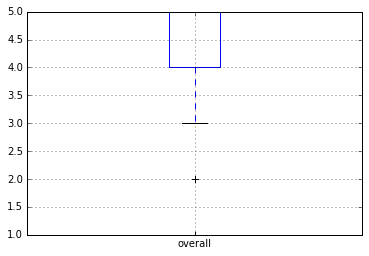

In [51]:
# well the data is definetly skewed toward meing more positive -- 
# will this affect training? will we have to down sample / upsample
# the targets that are overly / not well represented?
df.boxplot(column='overall', return_type='axes')

In [66]:
## lets figure out if there is any signal coming from the length of the post
df['reviewLength'] = df.apply(lambda x: len(x['reviewText']), axis=1)

In [70]:
df[['reviewLength', 'overall']]

,reviewLength,overall
0,299,4.0
1,122,3.0
2,251,3.0
3,153,5.0
4,148,4.0
5,236,5.0
6,760,5.0
7,207,5.0
8,135,5.0
9,107,5.0


In [72]:
# so there is a slight negative correlation between review length and score?
# so, as a review gets longer, it might get more negative, but the effect is not very strong
df[['reviewLength', 'overall']].corr()

,reviewLength,overall
reviewLength,1.000000,-0.076519
overall,-0.076519,1.000000


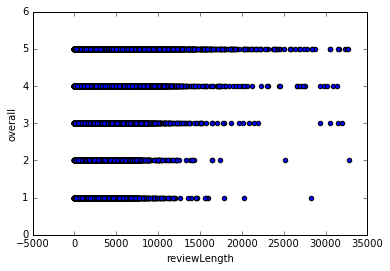

In [86]:
df[['reviewLength', 'overall']].iloc[0:100000].plot.scatter(x='reviewLength', y='overall')

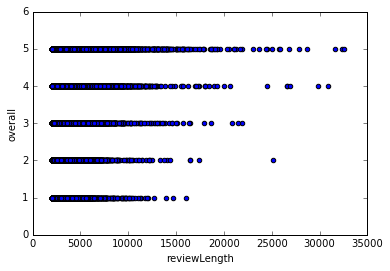

In [92]:
df[df['reviewLength'] > 2000][['reviewLength', 'overall']].iloc[0:100000].plot.scatter(x='reviewLength', y='overall')

In [90]:
df[df['reviewLength'] > 1000]['reviewLength'].describe()

count    499343.000000
mean       2259.295108
std        1482.053648
min        1001.000000
25%        1319.000000
50%        1801.000000
75%        2684.000000
max       32766.000000
Name: reviewLength, dtype: float64

anyway, it seems like the hit you take from being long doesnt have a huge effect. so we won't worry about it too much. but we will add a bit at some point to see if length has any effect on the classifier

might also be worth binning the lengths and looking at the average score

In [31]:
nrows = df.shape[0]
nrows

1697533

In [32]:
counter = 0
with open('labels.txt', 'w') as f:  
    ## we need to make a dataset for fasttext
    for idx, row in df.iterrows():
        ## make sure there are no pesky new line characters
        review = row['reviewText'].replace("\n", " ")
        #rating = "__label__" + str(row['overall'])[0]
        rating = str(row['overall'])[0]
        f.write(rating)
        #f.write(" ")
        #f.write(review)
        f.write("\n")
        counter += 1
        if (counter % 10000 == 0):
            print(counter, "of", nrows)

10000 of 1697533
20000 of 1697533
30000 of 1697533
40000 of 1697533
50000 of 1697533
60000 of 1697533
70000 of 1697533
80000 of 1697533
90000 of 1697533
100000 of 1697533
110000 of 1697533
120000 of 1697533
130000 of 1697533
140000 of 1697533
150000 of 1697533
160000 of 1697533
170000 of 1697533
180000 of 1697533
190000 of 1697533
200000 of 1697533
210000 of 1697533
220000 of 1697533
230000 of 1697533
240000 of 1697533
250000 of 1697533
260000 of 1697533
270000 of 1697533
280000 of 1697533
290000 of 1697533
300000 of 1697533
310000 of 1697533
320000 of 1697533
330000 of 1697533
340000 of 1697533
350000 of 1697533
360000 of 1697533
370000 of 1697533
380000 of 1697533
390000 of 1697533
400000 of 1697533
410000 of 1697533
420000 of 1697533
430000 of 1697533
440000 of 1697533
450000 of 1697533
460000 of 1697533
470000 of 1697533
480000 of 1697533
490000 of 1697533
500000 of 1697533
510000 of 1697533
520000 of 1697533
530000 of 1697533
540000 of 1697533
550000 of 1697533
560000 of 1697533
5

###### lets hope that the data is not in any sort of order -- we want a random sample for a train / test split!

In [7]:
counter = 0
with open('labeled_reviews.txt', 'w') as f:  
    ## we need to make a dataset for fasttext
    for idx, row in df.iterrows():
        ## make sure there are no pesky new line characters
        review = row['reviewText'].replace("\n", " ")
        rating = "__label__" + str(row['overall'])[0]
        f.write(rating)
        f.write(" ")
        f.write(review)
        f.write("\n")
        counter += 1
        if (counter % 10000 == 0):
            print(counter, "of", nrows)

1000 of 1697533
2000 of 1697533
3000 of 1697533
4000 of 1697533
5000 of 1697533
6000 of 1697533
7000 of 1697533
8000 of 1697533
9000 of 1697533
10000 of 1697533
11000 of 1697533
12000 of 1697533
13000 of 1697533
14000 of 1697533
15000 of 1697533
16000 of 1697533
17000 of 1697533
18000 of 1697533
19000 of 1697533
20000 of 1697533
21000 of 1697533
22000 of 1697533
23000 of 1697533
24000 of 1697533
25000 of 1697533
26000 of 1697533
27000 of 1697533
28000 of 1697533
29000 of 1697533
30000 of 1697533
31000 of 1697533
32000 of 1697533
33000 of 1697533
34000 of 1697533
35000 of 1697533
36000 of 1697533
37000 of 1697533
38000 of 1697533
39000 of 1697533
40000 of 1697533
41000 of 1697533
42000 of 1697533
43000 of 1697533
44000 of 1697533
45000 of 1697533
46000 of 1697533
47000 of 1697533
48000 of 1697533
49000 of 1697533
50000 of 1697533
51000 of 1697533
52000 of 1697533
53000 of 1697533
54000 of 1697533
55000 of 1697533
56000 of 1697533
57000 of 1697533
58000 of 1697533
59000 of 1697533
60000 

so we are using the default fasttext learning model (which is what? a neural net?), with 5 epochs, using an 80/20 training split. we have it set to just "unigrams" which is to say that its not "learning" bigrams -- need to look into this.

## Naive Model (attempt 1)

In [ ]:
cats
__label__4
i loved this moview
__label__5
i hated this movie 
__label__1
movies like this are great
__label__5
movies like this are terrible
__label__1


if these "easy" changes dont really increase accuracy that much, we should do the "hard" analysis and actually see where our model is doing well and where it is doing poorly and try to gain some insight

so now im trying to preprocess the text first, the idea being 1) the vocabulary will be smaller, which might a) be fewer params for the model to learn (still have to read the paper) and b) the same word that appears with a period or in uppercase (for example at the beg of a sentence) will not be the same entity, so whatever contexts have been learned for them will be merged, so perhaps the sharing of that information will make the model more precise on that one entity now than before, i.e. it has more contexts, might be better able to generalize, etc ... 

cat labeled_reviews.txt | sed -e "s/([.!?,'/()])/ 1 /g" | tr "[:upper:]" "[:lower:]" > movies.preprocessed.txt

using bash to process data is cool!

In [ ]:
ok so it budged when i made it consider bigrams

joshuamalina@Joshuas-MacBook-Pro-2 ~/d/movies> fasttext test model.movies.bin movies.preprocessed.valid  
N	339507
P@1	0.659
R@1	0.659
Number of examples: 339507

In [ ]:
interestingly, a lower learning rate always improved the precision

In [ ]:
joshuamalina@Joshuas-MacBook-Pro-2 ~/d/movies> ./test.sh 
BEGIN
0.1
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1064823  lr: 0.000000  loss: 0.772600  eta: 0h0m m 
N	339507
P@1	0.659
R@1	0.659
Number of examples: 339507

BEGIN
0.2
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1042450  lr: 0.000000  loss: 0.760522  eta: 0h0m 
N	339507
P@1	0.653
R@1	0.653
Number of examples: 339507

BEGIN
0.3
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1024664  lr: 0.000000  loss: 0.755202  eta: 0h0m 
N	339507
P@1	0.651
R@1	0.651
Number of examples: 339507

BEGIN
0.4
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1043209  lr: 0.000000  loss: 0.755358  eta: 0h0m 
N	339507
P@1	0.651
R@1	0.651
Number of examples: 339507

BEGIN
0.5
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1022692  lr: 0.000000  loss: 0.753736  eta: 0h0m 
N	339507
P@1	0.649
R@1	0.649
Number of examples: 339507

BEGIN
0.6
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1084230  lr: 0.000000  loss: 0.818311  eta: 0h0m 
N	339507
P@1	0.649
R@1	0.649
Number of examples: 339507

BEGIN
0.7
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1076990  lr: 0.000000  loss: 0.755232  eta: 0h0m 
N	339507
P@1	0.646
R@1	0.646
Number of examples: 339507

BEGIN
0.8
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1097927  lr: 0.000000  loss: 0.700342  eta: 0h0m 
N	339507
P@1	0.644
R@1	0.644
Number of examples: 339507

BEGIN
0.9
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1083960  lr: 0.000000  loss: 0.704557  eta: 0h0m 
N	339507
P@1	0.644
R@1	0.644
Number of examples: 339507

BEGIN
1.0
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1067443  lr: 0.000000  loss: 0.715676  eta: 0h0m 
N	339507
P@1	0.643
R@1	0.643
Number of examples: 339507

In [ ]:
BEGIN
0.1
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1064823  lr: 0.000000  loss: 0.772600  eta: 0h0m m 
N	339507
P@1	0.659
R@1	0.659
Number of examples: 339507

BEGIN
0.2
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1042450  lr: 0.000000  loss: 0.760522  eta: 0h0m 
N	339507
P@1	0.653
R@1	0.653
Number of examples: 339507

BEGIN
0.3
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1024664  lr: 0.000000  loss: 0.755202  eta: 0h0m 
N	339507
P@1	0.651
R@1	0.651
Number of examples: 339507

BEGIN
0.4
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1043209  lr: 0.000000  loss: 0.755358  eta: 0h0m 
N	339507
P@1	0.651
R@1	0.651
Number of examples: 339507

BEGIN
0.5
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1022692  lr: 0.000000  loss: 0.753736  eta: 0h0m 
N	339507
P@1	0.649
R@1	0.649
Number of examples: 339507

BEGIN
0.6
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1084230  lr: 0.000000  loss: 0.818311  eta: 0h0m 
N	339507
P@1	0.649
R@1	0.649
Number of examples: 339507

BEGIN
0.7
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1076990  lr: 0.000000  loss: 0.755232  eta: 0h0m 
N	339507
P@1	0.646
R@1	0.646
Number of examples: 339507

BEGIN
0.8
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1097927  lr: 0.000000  loss: 0.700342  eta: 0h0m 
N	339507
P@1	0.644
R@1	0.644
Number of examples: 339507

BEGIN
0.9
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1083960  lr: 0.000000  loss: 0.704557  eta: 0h0m 
N	339507
P@1	0.644
R@1	0.644
Number of examples: 339507

BEGIN
1.0
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1067443  lr: 0.000000  loss: 0.715676  eta: 0h0m 
N	339507
P@1	0.643
R@1	0.643
Number of examples: 339507

joshuamalina@Joshuas-MacBook-Pro-2 ~/d/movies> vi test.sh
joshuamalina@Joshuas-MacBook-Pro-2 ~/d/movies> ./test.sh > testing_epochs_and_learning_rate
./test.sh: line 14: syntax error: unexpected end of file
joshuamalina@Joshuas-MacBook-Pro-2 ~/d/movies> ./test.sh
./test.sh: line 14: syntax error: unexpected end of file
joshuamalina@Joshuas-MacBook-Pro-2 ~/d/movies> vi test.sh
joshuamalina@Joshuas-MacBook-Pro-2 ~/d/movies> ./test.sh > testing_epochs_and_learning_rate
Read 236M words^[^[
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1060920  lr: 0.000000  loss: 0.894319  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1046925  lr: 0.000000  loss: 0.883131  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1063102  lr: 0.000000  loss: 0.765177  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1076385  lr: 0.000000  loss: 0.771816  eta: 0h0m 4m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1068624  lr: 0.000000  loss: 0.666950  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1057871  lr: 0.000000  loss: 0.547344  eta: 0h0m m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1073525  lr: 0.000000  loss: 0.763699  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1064129  lr: 0.000000  loss: 0.688292  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1056036  lr: 0.000000  loss: 0.533205  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1077244  lr: 0.000000  loss: 0.732160  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1066405  lr: 0.000000  loss: 0.628854  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1059979  lr: 0.000000  loss: 0.525804  eta: 0h0m m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1074174  lr: 0.000000  loss: 0.758102  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1063802  lr: 0.000000  loss: 0.666267  eta: 0h0m 
Number of examples: 339507
Read 236M words
Number of words:  4167627
Number of labels: 5
Progress: 100.0%  words/sec/thread: 1060916  lr: 0.000000  loss: 0.503459  eta: 0h0m 
Number of examples: 339507
joshuamalina@Joshuas-MacBook-Pro-2 ~/d/movies> less testing_epochs_and_learning_rate 
joshuamalina@Joshuas-MacBook-Pro-2 ~/d/movies> less testing_epochs_and_learning_rate 

BEGIN
learning rate 0.01
num epochs 5
N       339507
P@1     0.637
R@1     0.637

BEGIN
learning rate 0.01
num epochs 10
N       339507
P@1     0.655
R@1     0.655

BEGIN
learning rate 0.01
num epochs 15
N       339507
P@1     0.66
R@1     0.66

BEGIN
learning rate 0.04
num epochs 5
N       339507
P@1     0.661
R@1     0.661

BEGIN
learning rate 0.04
num epochs 10
N       339507
P@1     0.655
R@1     0.655
testing_epochs_and_learning_rate

In [ ]:
might want to try increasing the dimensionality of the word / sentence vectors

we really need to look at the distribution of errors. what are they incorrectly predicting and why?

In [10]:
import fasttext

In [11]:
fasttext.load_model('model.movies.bin')

Exception: fastText: Cannot load model.movies.bin due to C++ extension failed to allocate the memory

In [ ]:
model = fasttext.supervised(input_file='movies.preprocessed.train', \
                    output='model_lr_04_epoch_5_ngrams_3_emb_300', \
                    dim=300, \
                    word_ngrams=3, 
                    epoch=5)

In [1]:
1+1

2

In [93]:
vecs = []
with open('review_vectors.txt', 'r') as f:
    with open('review_vectors_clean', 'w') as ff:
        ls = f.readlines()
        for l in ls:
            parts = l.split(' ')
            vec = parts[-101:-1]
            vec = list(map(lambda x: float(x), vec))
            vecs.append(vec)

In [67]:
with open('review_vectors_clean', 'r') as f:
    l = f.readline()
    print(l)

0.016051 0.12057 -0.06737 0.0043932 0.11127 -0.010199 -0.015874 0.040441 0.026757 0.078335 0.018461 0.022986 -0.0070111 0.080225 0.047282 -0.060775 0.036818 -0.0040064 0.048193 0.056838 -0.10669 -0.044939 0.016606 -0.037385 -0.069062 0.026022 0.096197 -0.036572 0.0060092 -0.010497 -0.038409 9.6061e-05 0.03998 0.016378 0.03852 0.011253 -0.020887 -0.065213 0.060221 0.11804 0.055575 0.080329 -0.067539 0.063979 -0.067433 -0.050932 0.0060643 0.083539 0.051772 0.10461 -0.05688 -0.0033336 -0.080524 0.057396 -0.068557 -0.049274 -0.036987 -0.077541 0.045895 0.057291 0.0038837 -0.0090696 0.17137 -0.086732 -0.029844 0.053889 0.010123 -0.0057181 -0.10259 -0.012729 -0.077592 -0.036338 0.20425 -0.070563 -0.10558 0.037965 -0.030828 -0.048266 0.083954 0.061895 -0.090573 0.062647 -0.00096994 -0.11337 -0.076072 0.10858 -0.11236 -0.10825 0.0045284 0.043185 -0.18823 0.032295 0.072339 -0.053426 -0.16778 0.0094829 -0.083266 0.039626 -0.047427 -0.051245 



In [68]:
import pandas as pd

In [33]:
from sklearn import linear_model

In [105]:
model = linear_model.LogisticRegression()

In [106]:
model.fit(X=vecs, y=truth)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [110]:
model.predict(vecs[100])

/Users/joshuamalina/tools/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 5.])

In [94]:
linear_model.Lo

In [98]:
truth = df.overall.as_matrix()

In [100]:
truth.shape

(1697533,)

In [114]:
import subprocess

In [112]:
cmd="ls"

In [115]:
process = subprocess.Popen(cmd, )

In [116]:
process.communicate()

(None, None)